In [1]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
from skimage import io, img_as_float
import base64

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from IPython.display import clear_output
import importlib

import utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## set up paths

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,analysis_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,analysis_dir,'gallery'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = map(make_dir_if_not_exists,[results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir])

## establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27017:127.0.0.1:27017 hhuey@cogtoolslab.org

In [28]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
if socket.gethostname().split('_')[0]=='Holly':
    conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017') #this was formerly "@127.0.0.1:27019" -- why?
else:
    conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017') 
db = conn['causaldraw']
coll = db['machines']

# which iteration name should we use?
iterationName = 'run2'

In [29]:
## how many records do we have in mongo? (this is total stroke records)
print('We have {} records in mongo.'.format(coll.estimated_document_count()))

We have 22496 records in mongo.


In [30]:
## grab me one of these records, plz
## this find one record from current iteration, drawing phase
coll.find_one({'iterationName':iterationName, 'phase': 'draw'})

{'_id': ObjectId('60402e1a2946d96bfd986a50'),
 'type': 'jspsych-cued-drawing',
 'iterationName': 'run2',
 'dev_mode': False,
 'toy_type': 'levers',
 'toy_variant': '2',
 'condition': 'explanatory',
 'demo_seq': 'ABBA',
 'version': 127,
 'file_id': 'levers_2_ABBA_30',
 'stim_url': 'https://causaldraw.s3.amazonaws.com/levers_2_ABBA_30.mp4',
 'demo_dur': 30,
 'phase': 'draw',
 'prolificID': '603ec4f1293b95e1ab7de241',
 'studyID': '603e884727b06c0008dac69f',
 'sessionID': '60402bb76bbfdf20b8017563',
 'gameID': '5790-6719857c-3fbd-4214-82ea-796caf5e115b',
 'recruitmentPlatform': 'prolific',
 'wID': '',
 'hitID': '',
 'aID': '',
 'trialNum': 0,
 'prompt': '<colexp>Draw how this artifact <i>functions</i> for the red alien!</colexp>',
 'eventType': 'stroke',
 'workerId': '',
 'svg': 'M189,325c-1.82713,0 -1.04548,6.09096 -2,8c-3.59588,7.19176 26.37919,17.86242 31,4c5.59777,-16.79332 -22.2834,-24.7166 -33,-14c-0.12727,0.12727 3.60934,3.82801 4,5c0.9197,2.75909 -1.30418,7.39164 0,10c0.27354,0.547

In [31]:
## check: what are all the iterationNames in mongo?
coll.find({'eventType':'stroke', 'phase': 'draw'}).distinct('iterationName')

['sandboxtest0',
 'livetest0',
 'testing3',
 'testing4',
 'run1',
 'debug',
 'debug1',
 'run2',
 'run3']

### Generate dataframes

In [32]:
## dump all stroke records into stroke df (of current iteration)
t = coll.find({'iterationName':iterationName, 'eventType':'stroke', 'phase': 'draw'})
T = pd.DataFrame(t)

## dump all sketch records into sketch df
k = coll.find({'iterationName':iterationName, 'eventType':'sketch', 'phase': 'draw'})
K = pd.DataFrame(k)

print('We have {} unique stroke records in all {} of our incomplete games.'.format(T.shape[0],K['gameID'].nunique()))
print('We have {} unique sketch records in all {} of our incomplete games.'.format(K.shape[0],K['gameID'].nunique())) 
## here's a table of all the gameIDs and how many trials in each
# K.groupby('gameID').count()['trialNum'].reset_index()

We have 528 unique stroke records in all 4 of our incomplete games.
We have 24 unique sketch records in all 4 of our incomplete games.


In [19]:
## pull out all data for a single, example sketch
# example = coll.find({'iterationName':iterationName, 'eventType':'stroke', 'phase': 'draw', 'gameID': '4621-e895c1a2-bb35-4aaa-9dea-1fbe89a16b08', 'toy_type': 'gears', 'toy_variant': '1'})
# e = pd.DataFrame(example)
# E = e.to_dict(orient='records')
# E

In [33]:
## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameID']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==6] ## get gameids that contributed exactly 6 sketches

In [34]:
## informal list of invalid gameids (e.g., only drew aliens)
invalid_gameids = ['8412-0ff784f1-021a-4e29-a013-0a69fc96dcb2', '4893-26ef64b2-9251-46ed-8f79-7921af54a772']
complete_gameids = [i for i in complete_gameids if i not in invalid_gameids]

In [35]:
## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameID'].nunique()!=len(complete_gameids)):
    T = T[(T['gameID'].isin(complete_gameids)) & (T['phase'] != 'practice')].reset_index(drop=True)
    K = K[(K['gameID'].isin(complete_gameids)) & (K['phase'] != 'practice')].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))    

We have 528 unique stroke records in all 4 of our complete games.
We have 24 unique sketch records in all 4 of our complete games.


In [36]:
## create dataframe of survey data
w = coll.find({'iterationName':iterationName, 'eventType':'survey'})
W = pd.DataFrame(w)

In [37]:
## save out to csv
csv_subdir = os.path.join(csv_dir,iterationName)
T.to_csv(os.path.join(csv_subdir,'causaldraw_stroke_data_{}.csv'.format(iterationName)),index=False)
K.to_csv(os.path.join(csv_subdir,'causaldraw_sketch_data_{}.csv'.format(iterationName)),index=False)
W.to_csv(os.path.join(csv_subdir,'causaldraw_survey_data_{}.csv'.format(iterationName)),index=False)

### Render out sketches and save to file

In [38]:
reallyRun = 0
importlib.reload(utils)
if reallyRun:
    utils.render_images(K, out_dir = os.path.join(sketch_dir,iterationName))

Done rendering 24 images to /Users/hollyhuey/causaldraw/original/analysis/sketches/run2.


### Construct sketch gallery (by machine and condition)

In [ ]:
## select sketches
# sketch_paths = sorted([sketch_path for sketch_path in os.listdir(os.path.join(sketch_dir,iterationName)) if sketch_path != '.DS_Store'])
# gameids = list(np.unique([i.split('_')[0] for i in sketch_paths]))

In [26]:
## select sketches from current IterationName
currIter_sketch_paths = K['gameID'] + '_' + K['toy_type'] + '_' + K['toy_variant'] + '_' + K['condition'] + '.png'
currIter_sketch_paths = sorted(currIter_sketch_paths)

In [27]:
reallyRun = 0
importlib.reload(utils)
if reallyRun:
    utils.render_sketch_gallery(complete_gameids, 
                      sketch_dir = os.path.join(sketch_dir,iterationName), 
                      gallery_dir = os.path.join(gallery_dir,iterationName),
                      num_trials=6)

Done saving gallery figures to /Users/hollyhuey/causaldraw/original/analysis/gallery/run3!


## Basic Analyses

In [ ]:
# take records in collection and convert into a pandas dataframe
# for diff drawings, make histogram of num strokes and histogram of average arc length (to check data objects are able to be analyzed as descriptives)
# rt, of total canvas what pixels are drawn in (mean pixel are intensity), use python image library to count (pillow, PIL import image) pixels in png, 

In [12]:
T['totalStrokeTime'] = T['endStrokeTime'] - T['startStrokeTime']

### How many strokes do participants draw?

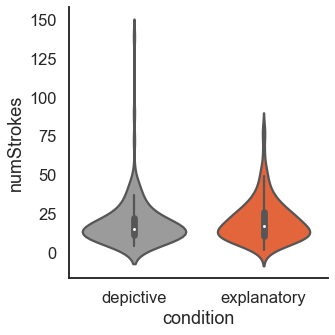

In [16]:
sns.catplot(data=K,
                x='condition',
                y='numStrokes',
                palette=sns.color_palette(['#9B9B9B', '#FF5720']),
                kind='violin')

plt.tight_layout()

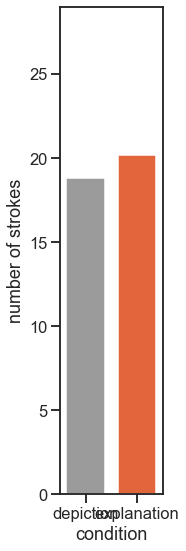

In [14]:
# plt.rcParams["axes.labelsize"] = 15
# plt.rcParams["xtick.labelsize"] = 15
# plt.rcParams["ytick.labelsize"] = 15

g = sns.barplot(data=K,
                x='condition',
                y='numStrokes', 
                palette=sns.color_palette(['#9B9B9B', '#FF5720']),
                ci=None,
               )
g.set(xticklabels=["depiction", "explanation"])
sns.set_style("ticks")

plt.ylim(0, 29)
l = plt.ylabel('number of strokes')
# m = plt.title('number of strokes per condition')

x1, x2 = 0, 1
y1, y2 = 24, 24
h, col = 0.5, 'k'

def change_width(g, new_value) :
    for patch in g.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(g, .75)

# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "", ha='center', va='bottom', color=col)

plt.tight_layout(rect=[0, 0, .45, 2])
plt.savefig('Nstrokes_perCondition.pdf', format='pdf', dpi=300, bbox_inches = "tight")

In [20]:
d = K.groupby(['gameID','condition'])['numStrokes'].mean().reset_index()
p = d.pivot(values='numStrokes',columns='condition',index='gameID').reset_index()
p['depictive'].mean()
# p['explanatory'].mean()

18.78666666666667

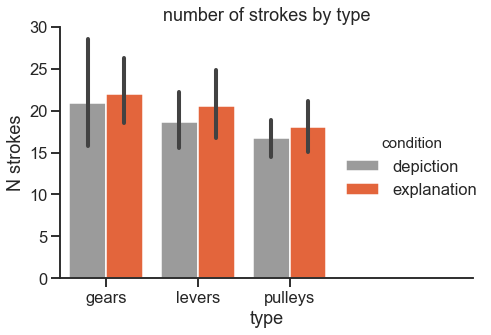

In [18]:
# number of strokes by toy_type
g = sns.catplot(data = K, 
            x = 'toy_type',
            y = 'numStrokes',
            hue='condition',
            kind='bar', 
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
            )

newlabels = ["depiction", "explanation"]
for t, l in zip(g._legend.texts, newlabels): t.set_text(l)

l = plt.ylabel('N strokes')
m = plt.xlabel('type')
n = plt.title('number of strokes by type')

plt.xlim(-0.5, 4)
plt.tight_layout()
plt.savefig('NStrokes_perTypeCondition.pdf', format='pdf')

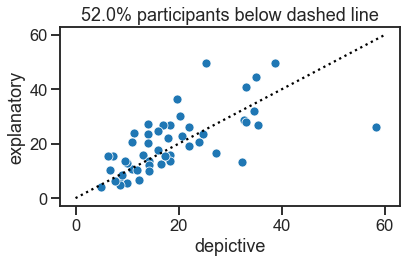

In [19]:
##### plot individual variation in numStrokes by condition
d = K.groupby(['gameID','condition'])['numStrokes'].mean().reset_index()
p = d.pivot(values='numStrokes',columns='condition',index='gameID').reset_index()
p['diff'] = p['depictive'] - p['explanatory']
prop = np.sum(p['diff'].values>0)/len(p)
sns.set_context('talk')

sns.scatterplot(data=p, 
                x='depictive',
                y='explanatory')

bound = 60
plt.plot((0,bound),(0,bound),'k:')
plt.title('{}% participants below dashed line'.format(prop.round(2)*100))

plt.tight_layout()
plt.savefig('NStrokes_indivVar.pdf', format='pdf')

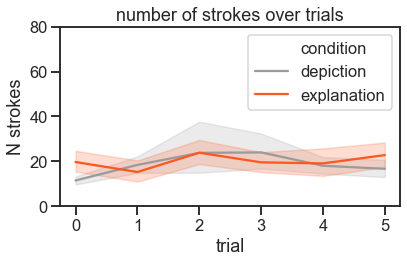

In [20]:
## num strokes across trial number
sns.lineplot(data=K, 
            x='trialNum',
            y='numStrokes',
            hue='condition', 
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
            )

L=plt.legend()
L.get_texts()[1].set_text('depiction')
L.get_texts()[2].set_text('explanation')
    
plt.xlabel('trial')
plt.ylabel('N strokes')
plt.ylim(0,80)
m = plt.title('number of strokes over trials')

plt.tight_layout()

plt.savefig('Nstrokes_overTime.pdf', format='pdf')

### How long are the strokes they do make?

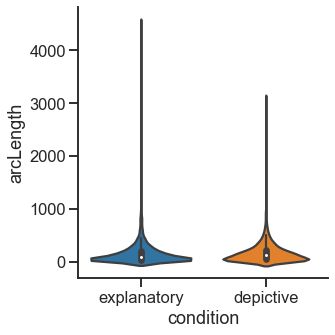

In [22]:
sns.catplot(data=T,
                x='condition',
                y='arcLength',
                kind='violin')

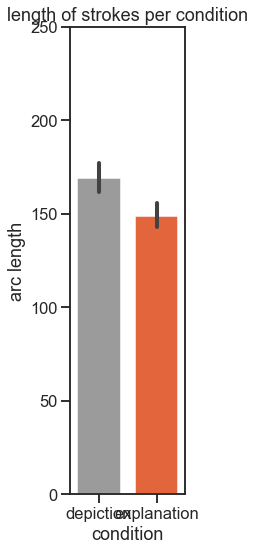

In [30]:
## plot mean arc length
g = sns.barplot(data=T, 
            x='condition',
            y='arcLength', 
            order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
            )
g.set(xticklabels=["depiction", "explanation"])

plt.ylim(0, 250)
l = plt.ylabel('arc length')
m = plt.title('length of strokes per condition')

x1, x2 = 0, 1
y1, y2 = 200, 200
h, col = 10, 'k'

# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "*", ha='center', va='bottom', color=col)

change_width(g, .75)

plt.tight_layout(rect=[0, 0, .5, 2])

plt.savefig('arclength_perCondition_edited.pdf', format='pdf')

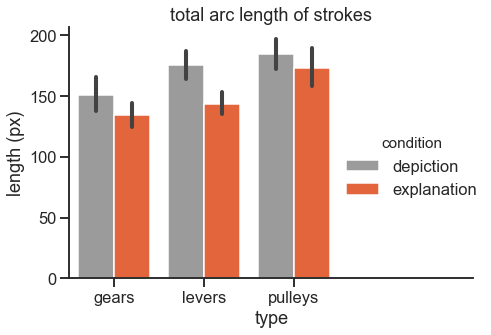

In [33]:
# arc length x condition x toy_type
g = sns.catplot(data = T, 
            x = 'toy_type',
            y = 'arcLength',
            hue='condition',
            kind='bar', 
            hue_order=['depictive', 'explanatory'],
            order=['gears', 'levers', 'pulleys'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
           )
newlabels = ["depiction", "explanation"]
for t, l in zip(g._legend.texts, newlabels): t.set_text(l)

l = plt.ylabel('length (px)')
m = plt.xlabel('type')
n = plt.title('total arc length of strokes')

plt.xlim(-0.5, 4)
plt.tight_layout()
plt.savefig('arclength_perTypeCondition.pdf', format='pdf')

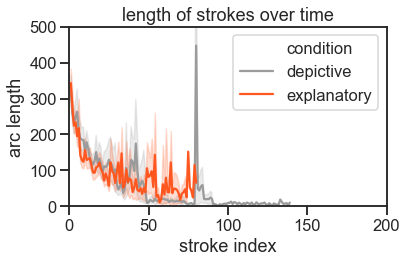

In [34]:
## arc length across stroke index
sns.lineplot(data=T, 
            x='currStrokeNum',
            y='arcLength',
            hue='condition', 
            hue_order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720']))
plt.xlabel('stroke index')
plt.ylabel('arc length')
plt.ylim(0,500)
plt.xlim(0,200)

m = plt.title('length of strokes over time')

plt.tight_layout()

plt.tight_layout()
plt.savefig('arclength_acrossStrokes.pdf', format='pdf')

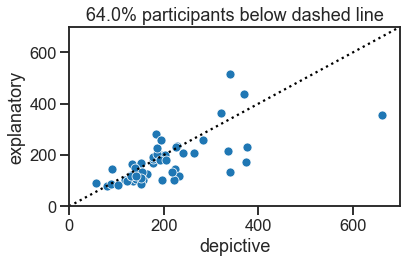

In [35]:
## plot individual variation in arcLength by condition
d = T.groupby(['gameID','condition'])['arcLength'].mean().reset_index()
p = d.pivot(values='arcLength',columns='condition',index='gameID').reset_index()
p['diff'] = p['depictive'] - p['explanatory']
prop = np.sum(p['diff'].values>0)/len(p)
sns.set_context('talk')
sns.scatterplot(data=p, 
                x='depictive',
                y='explanatory')

plt.ylim(0,700)
plt.xlim(0,700)
bound = 800
plt.plot((0,bound),(0,bound),'k:')
plt.title('{}% participants below dashed line'.format(prop.round(3)*100))

plt.tight_layout()
plt.savefig('arclength_indivVar.pdf', format='pdf')

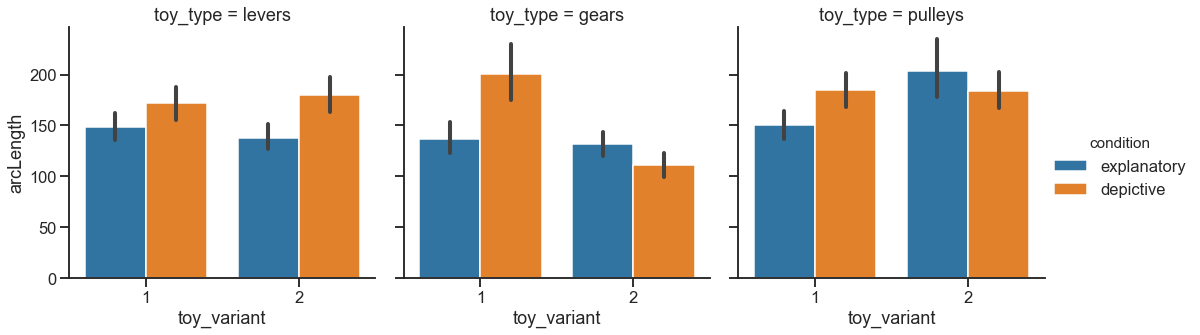

In [36]:
# arc length broken out by toy variant
sns.catplot(data = T, 
            x = 'toy_variant',
            y = 'arcLength',
            hue='condition',
            col='toy_type',
            kind='bar')    


### How long did participants spend drawing?

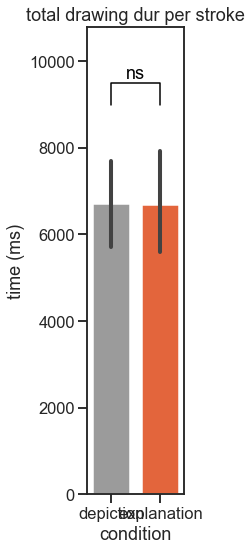

In [27]:
# plot drawing time per stroke
S = (T.groupby(['gameID','condition'])['totalStrokeTime'].max().reset_index())
g = sns.barplot(data=S,
            x='condition',
            y='totalStrokeTime', 
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
           )
g.set(xticklabels=["depiction", "explanation"])

l = plt.ylabel('time (ms)')
m = plt.title('total drawing dur per stroke')

plt.ylim(0, 10800)

x1, x2 = 0, 1
y1, y2 = 9000 , 9000
h, col = 500, 'k'

plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y1+h, "ns", ha='center', va='bottom', color=col)
plt.tight_layout()

change_width(g, .75)
plt.tight_layout(rect=[0, 0, .5, 2])

plt.savefig('drawtime_perStroke_edited.pdf', format='pdf', dpi=300, bbox_inches = "tight")

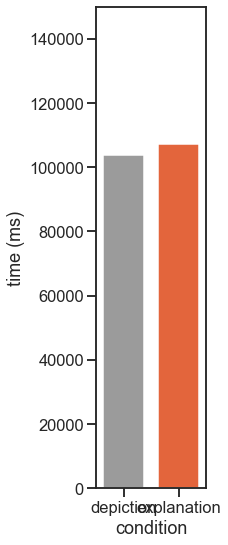

In [16]:
K = K.assign(totalTrialTime = K['endTrialTime'] - K['startTrialTime'])

g = sns.barplot(data=K,
            x='condition',
            y='totalTrialTime',
            palette=sns.color_palette(['#9B9B9B', '#FF5720']),
            ci=None,
            )
g.set(xticklabels=["depiction", "explanation"])

plt.ylim(0, 150000)
l = plt.ylabel('time (ms)')
# m = plt.title('total drawing time per trial')

x1, x2 = 0, 1
y1, y2 = 130000 , 130000
h, col = 3000, 'k'

# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "", ha='center', va='bottom', color=col)
plt.tight_layout()

change_width(g, .75)
plt.tight_layout(rect=[0, 0, .55, 2])

plt.savefig('drawtime_perTrial.pdf', format='pdf', dpi=300, bbox_inches = "tight")

In [34]:
totaltime = K.groupby(['gameID','condition'])['totalTrialTime'].mean().reset_index()
totaltime_piv = totaltime.pivot(values='totalTrialTime',columns='condition',index='gameID').reset_index()
totaltime_piv['depictive'].mean()/1000
totaltime_piv['explanatory'].mean()/1000

107.09304666666668

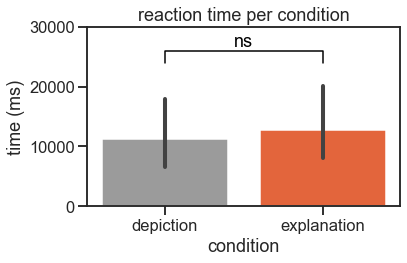

In [47]:
RT = T.groupby(['gameID', 'file_id', 'startResponseTime']).first().reset_index()
RT = pd.DataFrame(RT)
RT['rt'] = RT['startStrokeTime'] - RT['startResponseTime']

g = sns.barplot(data=RT,
            x='condition',
            y='rt',
            order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720']))

g.set(xticklabels=["depiction", "explanation"])

plt.ylim(0, 30000)
l = plt.ylabel('time (ms)')
m = plt.title('reaction time per condition')

x1, x2 = 0, 1
y1, y2 = 24000 , 24000
h, col = 2000, 'k'

plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y1+h, "ns", ha='center', va='bottom', color=col)
plt.tight_layout()

plt.savefig('drawtime_perTrial.pdf', format='pdf')

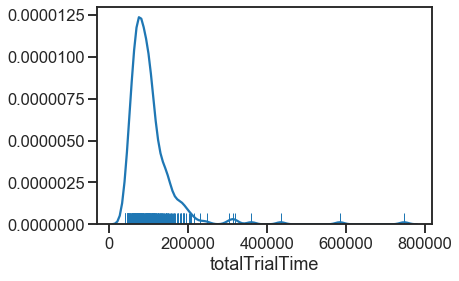

In [48]:
sns.distplot(K['totalTrialTime'], rug=True, hist=False)

### Exactly how much ink are participants using?

In [49]:
def RGBA2RGB(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.
    Simpler, faster version than the solutions above.
    Source: http://stackoverflow.com/a/9459208/284318
    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)
    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background

In [50]:
## convert ims into grayscale vectors and get mean pixel intensity from collections import Counter
meanpix = []

for i,f in enumerate(currIter_sketch_paths):
    im = Image.open(os.path.join(sketch_dir,iterationName,f))
    imarr = np.array(im)
    
    ## check image type
    # print(imarr.shape)
    
    ## convert RGBA into RBG
    im2 = RGBA2RGB(im)
    im2arr = np.array(im2)
    
    ## convert RBG into grayscale
    im3 = im2.convert(mode='L')
    imarr3 = np.array(im3)
    
    ## convert to vector
    imvec = imarr3.flatten() 

    ## normalize to 0,1 and set ink to 1, and blank to 0
    imvec_inv = (255 - imvec)/255 

    ## check range of vector is correct
    # print(np.max(imvec_inv))
    # print(np.min(imvec_inv))

    ## get mean pixel intensity
    im.mean = np.mean(imvec_inv)
    meanpix.append(im.mean)
#     print('{} {}'.format(im.mean, f))

In [51]:
## meanpix
np.mean(meanpix)

0.05596124856735436

In [52]:
## save out to csv for R analysis
MP = pd.DataFrame(meanpix)
MP['sketchName'] = currIter_sketch_paths
new = MP['sketchName'].str.split("_", n = 3, expand = True)
new = new[3].str.split(".", n = 1, expand = True)

MP['condition'] = new[0]
MP['meanpix'] = MP[0]

# print(MP)
MP.to_csv(os.path.join(csv_dir,'meanpix_{}.csv'.format(iterationName)),index=False)

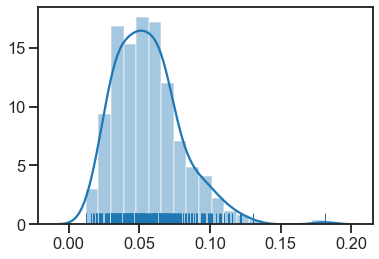

In [53]:
sns.distplot(meanpix, rug=True, hist=True)

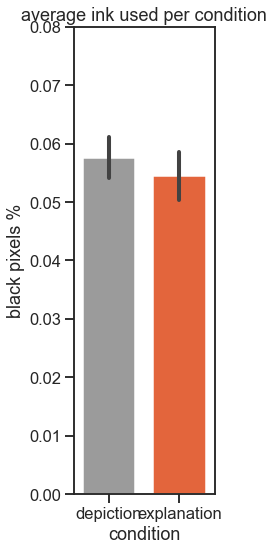

In [63]:
g = sns.barplot(data=MP, 
            x='condition',
            y='meanpix',
            order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
            )
g.set(xticklabels=["depiction", "explanation"])

plt.ylim(0, .08)
l = plt.ylabel('black pixels %')
m = plt.title('average ink used per condition')

x1, x2 = 0, 1
y1, y2 = .08 , .08
h, col = .007, 'k'

# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "ns", ha='center', va='bottom', color=col)

change_width(g, .75)
plt.tight_layout(rect=[0, 0, .57, 2])

plt.savefig('ink_perCondition_edited.pdf', format='pdf')

### Saving messy code here below

In [ ]:
## check image type
for i,f in enumerate(sketch_paths):
    im = Image.open(os.path.join(sketch_dir,f))
    imarr = np.array(im)
imarr.shape

In [ ]:
## convert RBGA to RBG (could skip this and go straight to grayscale)
im2 = RGBA2RGB(im)
im2arr = np.array(im2)
im2arr.shape

In [ ]:
## convert to grayscale with 'L'
im3 = im2.convert(mode='L')
imarr3 = np.array(im3)
imarr3.shape

In [ ]:
# np.unique(imarr3)
# h = plt.hist(imarr3.flatten(),bins=50)

In [ ]:
# from collections import Counter
# d = dict(Counter(imarr3.flatten()))
# for key in sorted(d.keys()):
#     print('pix value: {} | num pix: {}'.format(key, d[key]))

In [ ]:
## convert to vector
imvec = imarr3.flatten() 

## normalize to 0,1 and set ink to 1, and blank to 0
imvec_inv = (255 - imvec)/255 

## check range of vector is correct
print(np.max(imvec_inv))
print(np.min(imvec_inv))

## get mean pixel intensity
np.mean(imvec_inv)

In [ ]:
# for i,im in enumerate(sketch_paths):
#     im = Image.open(os.path.join(sketch_dir,f))
# #     count = len([px for px in list(im.getdata()) if px[1] < 0.01])
#     im = img_as_float(im)
#     plt.imshow(im)
#     nblack = im[np.where(im==0)].sum()
#     print(nblack)
# # print(count)

# print(im.shape[0] * im.shape[1])

#     black = 0
#     for pixel in im.getdata():
#         if pixel == (0, 0, 0): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
#             black += 1
#     print('black=' + str(black))


In [ ]:
for i,f in enumerate(sketch_paths):
    im = Image.open(os.path.join(sketch_dir,f))
    im = img_as_float(im)
plt.imshow(im);

In [ ]:
for i,f in enumerate(sketch_paths):
    im = Image.open(os.path.join(sketch_dir,f))
    im = np.array(im)
    white = np.count_nonzero(im)
    black = im.size - white
print(white)
print('black', np.count_nonzero(im!=0))
print(black)
print('white', np.count_nonzero(im==0))
print(im.size)
plt.imshow(im);

In [ ]:
# for i,f in enumerate(sketch_paths):
#     im = Image.open(os.path.join(sketch_dir,f)).convert('L')
# #     im = img_as_float(im)
#     na = np.array(im)
#     white = np.count_nonzero(im)
#     black = np.count_nonzero(im==0)
# # print(im)
# print(white)
# print(black)
# print(im.size)

In [ ]:
# for i,f in enumerate(sketch_paths):
#     im = Image.open(os.path.join(sketch_dir,f)).convert('L')
# #     im = Image.open(os.path.join(sketch_dir,f))
#     na = np.array(im)
#     white = np.count_nonzero(im)
#     black = np.count_nonzero(im==0)
#     print(im)
# print(white)
# print(black)

In [ ]:
for i,f in enumerate(sketch_paths):
    im = Image.open(os.path.join(sketch_dir,f))
    im = img_as_float(im)
#     print(im)
#     plt.imshow(im)
#     sns.set_style('white')  
#     p.axis('off')
#     plt.title('{} {} {}'.format(toy_type,toy_variant,condition))
#     fname = '{}.png'.format(gameid)
# print(fname)
# print(im.shape)
# print(f"The image consists of {im.shape[0] * im.shape[1]} pixels")
plt.imshow(im);

In [ ]:
for gind, game in enumerate(gameids): 
    game_sketch_paths = [path for path in sketch_paths if path.split('_')[0] == game]
    fig = plt.figure(figsize=(8,12))   
    for i,f in enumerate(game_sketch_paths):
        # open image
        im = Image.open(os.path.join(sketch_dir,f))
        # get metadata
        gameid = f.split('_')[0] 
        toy_type = f.split('_')[1]
        toy_variant = f.split('_')[2]
        condition = f.split('_')[3].split('.')[0]   
        # make gallery
        p = plt.subplot(3,2,i+1)
        plt.imshow(im)
        sns.set_style('white')
        k = p.get_xaxis().set_ticklabels([])
        k = p.get_yaxis().set_ticklabels([])
        k = p.get_xaxis().set_ticks([])
        k = p.get_yaxis().set_ticks([])   
        p.axis('off')
        plt.title('{} {} {}'.format(toy_type,toy_variant,condition))
    plt.suptitle(gameid)
    fname = '{}.png'.format(gameid)

In [ ]:
list1 = ['a', 'b', 'c']
list2 = ['x', 'y', 'z']

for i,j in enumerate(list1):
    for n,m in enumerate(list2):
        print('{} {}'.format(j, m))

In [ ]:
# ## plot numStrokes
# sns.barplot(data = T, 
#             x = 'condition',
#             y = 'currStrokeNum')

In [ ]:
sns.distplot(T['rt'], hist=False)

In [ ]:
K = K.assign(totalTrialTime = K['endTrialTime'] - K['startTrialTime'])

In [ ]:
sns.distplot(K['totalTrialTime'], hist=False)

In [ ]:
sns.barplot(data=K, y='totalTrialTime', x='workerId')

In [ ]:
sns.barplot(data=K,x='condition',y='totalTrialTime')
l = plt.ylabel('total trial time (ms)')
m = plt.title('total drawing time by condition')

In [ ]:
## plot arc length of toy type by condition
sns.catplot(data = T, 
            x = 'condition',
            y = 'arcLength',
            hue='toy_type',
            kind='violin')
l = plt.ylabel('length (px)')
m = plt.title('total arc length of strokes')

In [ ]:
## plot of arc length of toy variant by toy variant
sns.catplot(data = T, 
            x = 'condition',
            y = 'arcLength',
            hue='toy_variant',
            col='toy_type',
            kind='violin')

In [ ]:
## levers looks weird... is this coincidental that we haven't gotten a levers_1_explanatory or levers_2_depictive?
x = list(K['version'].unique())

for i, j in enumerate(x):
    version_check = coll.find({'eventType':'sketch', 'phase': 'draw', 'version': int(j), 'toy_type': 'levers'})
    v = pd.DataFrame(version_check)
    v2 = v[['version', 'toy_type', 'toy_variant', 'condition']]
    print(v2)

## note to self: yup this is coincidental